In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

# Purpose: predict the duration of a ride

In [2]:
url_january = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet"
url_february = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-02.parquet"

In [3]:
df_january = pd.read_parquet(url_january)
df_february = pd.read_parquet(url_february)

In [4]:
df = pd.concat([df_january, df_february], ignore_index=True)

In [5]:
df.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


# Q1. Downloading the data

Read the data for January. How many columns are there?

In [6]:
num_columns = df.shape[1]
num_columns

19

In [7]:
num_columns = len(df.columns)
num_columns

19

# Q2. Computing duration

Now let's compute the duration variable. It should contain the duration of a ride in minutes.

What's the standard deviation of the trips duration in January?

In [8]:
df_january['duration'] = (pd.to_datetime(df_january['tpep_dropoff_datetime']) - pd.to_datetime(df_january['tpep_pickup_datetime'])).dt.total_seconds() / 60

In [9]:
df_january.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,duration
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0,19.800000
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0,6.600000
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0,17.916667
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0,8.300000
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0,6.100000


In [10]:
std_duration = df_january['duration'].std()
std_duration

34.851053592192876

# Q3. Dropping outliers

Next, we need to check the distribution of the duration variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

What fraction of the records left after you dropped the outliers?

In [11]:
df_january['duration'] = (pd.to_datetime(df_january['tpep_dropoff_datetime']) - pd.to_datetime(df_january['tpep_pickup_datetime'])).dt.total_seconds() / 60

In [12]:
filtered_data = df_january[(df_january['duration'] >= 1) & (df_january['duration'] <= 60)]

In [13]:
fraction_left = len(filtered_data) / len(df_january)
fraction_left

0.9778326020432945

# Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

- Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will label encode them)
- Fit a dictionary vectorizer
- Get a feature matrix from it

 it
What's the dimensionality of this matrix (number of columns)?

In [14]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['duration']

In [15]:
filtered_data[categorical].dtypes

PULocationID    int32
DOLocationID    int32
dtype: object

In [16]:
# Re-cast the IDs to strings
filtered_data.loc[:, categorical] = filtered_data[categorical].astype(str)

In [17]:
filtered_data[categorical].dtypes

PULocationID    object
DOLocationID    object
dtype: object

In [18]:
# Keep three columns
df_selected = filtered_data[categorical]
df_selected.head()

,PULocationID,DOLocationID
0,186,79
1,140,236
2,236,79
3,79,211
4,211,148


In [19]:
# Convert the dataframe to a list of dictionaries
train_dicts = df_selected.to_dict(orient='records')

In [20]:
# Initialize the dictionary vectorizer
dv = DictVectorizer()
# Fit the vectorizer and transform the data into a feature matrix
X_train = dv.fit_transform(train_dicts)

In [21]:
dv.feature_names_

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=105',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=109',
 'DOLocationID=11',
 'DOLocationID=111',
 'DOLocationID=112',
 'DOLocationID=113',
 'DOLocationID=114',
 'DOLocationID=115',
 'DOLocationID=116',
 'DOLocationID=117',
 'DOLocationID=118',
 'DOLocationID=119',
 'DOLocationID=12',
 'DOLocationID=120',
 'DOLocationID=121',
 'DOLocationID=122',
 'DOLocationID=123',
 'DOLocationID=124',
 'DOLocationID=125',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=13',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=133',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=137',
 'DOLocationID=138',
 'DOLocationID=139',
 'DOLocationID=14',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=142',
 'DOLocationID=143',
 'DOLocationID=144',

In [22]:
X_train

<2898906x518 sparse matrix of type '<class 'numpy.float64'>'
	with 5797812 stored elements in Compressed Sparse Row format>

In [23]:
# Get the dimensionality of the feature matrix
num_columns = X_train.shape[1]
num_columns

518

# Q5. Training a model

Now let's use the feature matrix from the previous step to train a model.
- 
Train a plain linear regression model with default parameter- s
Calculate the RMSE of the model on the training d
ata
What's the RMSE on train?

In [24]:
# Get the Y
target = 'duration'
y_train = filtered_data[target].values

In [25]:
# Train a plain linear regression model with default parameters
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [26]:
# Make predictions on the training data
predictions = lr.predict(X_train)

# Calculate the RMSE on the training data
rmse = np.sqrt(mean_squared_error(y_train, predictions, squared=False))
rmse

2.818895975461326

/home/codespace/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/codespace/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


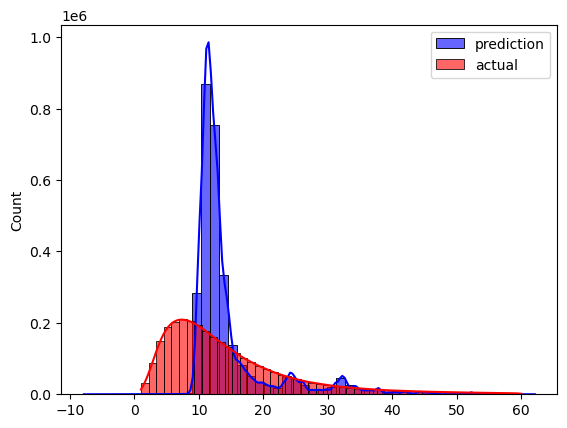

In [27]:
sns.histplot(predictions, kde=True, label='prediction', color='blue', alpha=0.6, bins=50)
sns.histplot(y_train, kde=True, label='actual', color='red', alpha=0.6, bins=50)

plt.legend()
plt.show()

# Q6. Evaluating the model

Now let's apply this model to the validation dataset (February 2023).

What's the RMSE on validation?

In [28]:
# Calculate the duration in minutes
df_february['duration'] = (pd.to_datetime(df_february['tpep_dropoff_datetime']) - pd.to_datetime(df_february['tpep_pickup_datetime'])).dt.total_seconds() / 60

In [ ]:
# Filter the data
filtered_data_february = df_february[(df_february['duration'] >= 1) & (df_february['duration'] <= 60)]

# Convert specified columns to string type using loc to avoid the SettingWithCopyWarning
filtered_data_february.loc[:, categorical] = filtered_data_february[categorical].astype(str)

# Keep only the relevant columns
df_selected_february = filtered_data_february[categorical]

In [ ]:
# Convert the dataframe to a list of dictionaries
data_dict_february = df_selected_february.to_dict(orient='records')

# Transform the validation data using the already fitted dictionary vectorizer
X_val = dv.transform(data_dict_february)

In [ ]:
# Target variable
y_val = filtered_data_february[target].values

# Make predictions on the validation data
predictions_val = model.predict(X_val)

# Calculate the RMSE on the validation data
rmse_val = np.sqrt(mean_squared_error(y_val, predictions_val))
print(f"The RMSE on the validation data is: {rmse_val:.2f}")